In [4]:
import json

from tqdm.auto import tqdm
import pandas as pd
import jinja2
from dotenv import load_dotenv
from openai import OpenAI

import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv("./.env")
client = OpenAI()

In [31]:
question_df = pd.read_csv("data/cri_questions.csv")

df = pd.read_csv("data/cri_responses.csv", index_col=0)
df = df.merge(question_df[["chunk_slug", "chunk_text", "question", "answer"]], on="chunk_slug")
df

,id,response,score,condition,user_id,page_slug,chunk_slug,prolific_pid,StartDate,EndDate,...,PQ09,PQ10,PQ11,PQ12,PQ13,PQ14,PQ15,chunk_text,question,answer
0,723,GDP for most regions in the world was under $1...,2,random_reread,v4fqbtjlczphvz73amvw536ltq,7-1-the-relatively-recent-arrival-of-economic-...,learning-objectives-700t,5fc29e457497e203c3af6bb9,2024-08-02 07:30:50,2024-08-02 07:36:41,...,1,1,1,0,0,1,0,Let’s begin with a brief overview of spectacul...,What were economic conditions like before 1870?,Economic conditions before 1870 were marked by...
1,725,"In 1870, economic conditions were marked by si...",1,stairs,qrttbpngg5dfjx3ofqqq6ztnnq,7-1-the-relatively-recent-arrival-of-economic-...,learning-objectives-700t,669e7ee87fdb883c4753b9b0,2024-08-02 07:32:05,2024-08-02 07:55:20,...,0,1,1,1,0,0,0,Let’s begin with a brief overview of spectacul...,What were economic conditions like before 1870?,Economic conditions before 1870 were marked by...
2,741,General calculations show that the 17 countrie...,1,stairs,aorxffqmynkoda3n6sac463cpy,7-1-the-relatively-recent-arrival-of-economic-...,learning-objectives-700t,66787d911f632efa3e47b36b,2024-08-03 08:38:28,2024-08-03 08:48:15,...,1,1,1,0,1,0,0,Let’s begin with a brief overview of spectacul...,What were economic conditions like before 1870?,Economic conditions before 1870 were marked by...
3,744,There was mostly global equality for 1300 year...,0,random_reread,3f3za2unfv65eub66342v5lkcm,7-1-the-relatively-recent-arrival-of-economic-...,learning-objectives-700t,5e0a4154deea2b2c63fb1062,2024-08-03 08:37:37,2024-08-03 08:45:50,...,1,1,0,1,1,0,1,Let’s begin with a brief overview of spectacul...,What were economic conditions like before 1870?,Economic conditions before 1870 were marked by...
4,754,"Before 1870, the economy worked differently th...",2,stairs,qskrn4ob7wb6uykn6fn57eohgy,7-1-the-relatively-recent-arrival-of-economic-...,learning-objectives-700t,66a8234bcd34188af3207270,2024-08-03 08:44:07,2024-08-03 09:07:13,...,0,1,0,0,1,1,0,Let’s begin with a brief overview of spectacul...,What were economic conditions like before 1870?,Economic conditions before 1870 were marked by...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2751,"When markets are not performing well, the gove...",2,random_reread,cb6lyd6mcr5mx6dom2mqidh2fa,7-3-components-of-economic-growth,A-Healthy-Climate-for-Economic-Growth-711t,60dfa0f80964725cfdab1685,2024-08-16 12:06:38,2024-08-16 12:16:05,...,1,0,1,0,1,0,0,While physical and human capital deepening and...,What are some examples of areas in which gover...,"Education, savings and investment, infrastruct..."
1436,2763,education and infrastructure,2,random_reread,v4xj35rkdentrlacqunbwb7j7q,7-3-components-of-economic-growth,A-Healthy-Climate-for-Economic-Growth-711t,667c022942ce4d110487ae7b,2024-08-16 12:08:07,2024-08-16 12:30:06,...,1,0,0,0,1,1,1,While physical and human capital deepening and...,What are some examples of areas in which gover...,"Education, savings and investment, infrastruct..."
1437,2775,"investing in education, infrastructure, and en...",2,stairs,xbg6bisthhc34j4gy5l6kzi7z4,7-3-components-of-economic-growth,A-Healthy-Climate-for-Economic-Growth-711t,656f6c6d08bb71fb9ccd0c4b,2024-08-16 12:09:39,2024-08-16 12:17:57,...,1,1,0,0,0,0,0,While physical and human capital deepening and...,What are some examples of areas in which gover...,"Education, savings and investment, infrastruct..."
1438,2785,"infrastructure development , education and tra...",1,stairs,n4rqud2tdmn3twdryzlwfg5qxi,7-3-components-of-economic-growth,A-Healthy-Climate-for-Economic-Growth-711t,66bf33860bd183d5643a40d6,2024-08-16 12:12:12,2024-08-16 12:29:12,...,0,1,1,0,1,0,1,While physical and human capital deepening and...,What are some examples of areas in which gover...,"Education, savings and investment, infrastruct..."


## Data Distribution

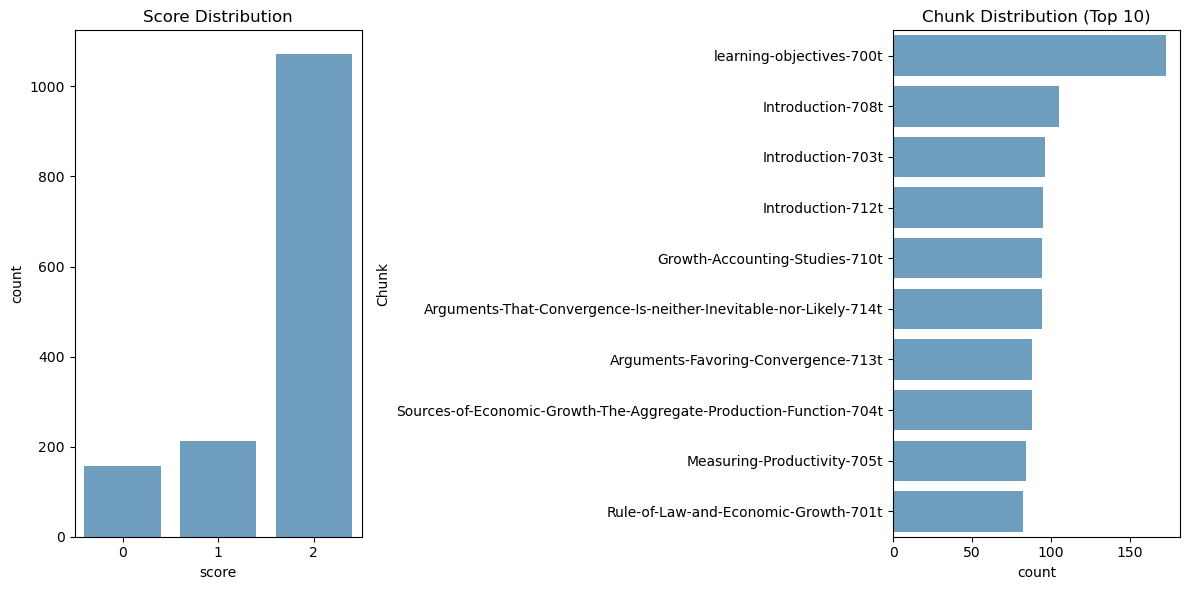

In [27]:
# Set up the plotting area
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot score distribution
sns.countplot(x='score', data=df, ax=axs[0], alpha=0.7)
axs[0].set_title('Score Distribution')

# Plot chunk distributions (top N chunks for clarity)
top_chunks = df['chunk_slug'].value_counts().head(10).index
top_chunk_df = df[df['chunk_slug'].isin(top_chunks)]

sns.countplot(y='chunk_slug', data=top_chunk_df, order=top_chunks, ax=axs[1], alpha=0.7)
axs[1].set_title('Chunk Distribution (Top 10)')
axs[1].set_ylabel('Chunk')

plt.tight_layout()
plt.show();

## Test Prompt

In [36]:
environment = jinja2.Environment(loader=jinja2.FileSystemLoader("prompts"))
template = environment.get_template("response-score.jinja2")

print(template.render(df.sample(1).to_dict(orient="records")[0]))

You are an expert educational assessment evaluator. Your task is to score a student's short answer response based on a specific rubric.

SCORING RUBRIC:
Please score the student's response according to the following construct map. Examples for each level of response are provided in response to the following example question and example reference answer:

Example Question: "What are some examples of areas in which governments invest to facilitate capital deepening and technology?"
Example Reference Answer: "Education, savings and investment, infrastructure, special economic zones, and scientific research."

Level 5: Expert Reading
- Characteristics: Student demonstrates strong engagement with the text and full comprehension of the material.
- Response Quality: Demonstrates a command of the material and ability to manipulate concepts to form cohesive and detailed answers.
- Example of Level 5 Response: "Education, infrastructure, scientific research funding, and special economic zones ar

# Score data

In [37]:
responses = []

for row in tqdm(df.itertuples(), total=len(df)):
    response = client.chat.completions.create(
        model="o3-mini-2025-01-31",
        messages=[{
            "role": "user",
            "content": template.render(
                chunk_text = row.chunk_text.strip(),
                question = row.question,
                answer = row.answer,
                response = row.response,
            )
        }],
        response_format={  # {"score": "1"}
            "type": "json_schema",
            "json_schema": {
                "name": "cri_score_schema",
                "schema": {
                    "type": "object",
                    "properties": {
                        "score": {
                            "description": "A single digit from 1-4 representing the score of the student's response",
                            "type": "integer"
                        },
                        "additionalProperties": False
                    }
                }
            }
        }
    )
    responses.append(response)

  0%|          | 0/1440 [00:00<?, ?it/s]

In [41]:
scores = [
    json.loads(response.choices[0].message.content)["score"]
    for response in responses
]

df["o3_mini_score"] = scores

df.sample(3)

,id,response,score,condition,user_id,page_slug,chunk_slug,prolific_pid,StartDate,EndDate,...,PQ10,PQ11,PQ12,PQ13,PQ14,PQ15,chunk_text,question,answer,o3_mini_score
537,2157,The relationship between girls' education in l...,2,random_reread,mhyc2ldfj7xrct4fz4nbkn32xe,7-3-components-of-economic-growth,Growth-Accounting-Studies-710t,6646419595602daa1e66b16b,2024-08-14 19:18:20,2024-08-14 19:52:55,...,1,0,1,0,1,0,"Since the late 1950s, economists have conducte...",What is the relationship between girls' educat...,Girls' education in low-income countries is a ...,3
1263,2431,"physical capital, human capital sand technology",2,stairs,sphuh2e2tdpqou3kcdbfcb6gm4,7-3-components-of-economic-growth,Introduction-708t,5fbc5a3e09412611f93aa1c2,2024-08-15 16:28:07,2024-08-15 16:34:50,...,0,0,1,0,1,1,"Over decades and generations, seemingly small ...",What are some of the components of economic gr...,"Physical capital, human capital, and technology.",5
307,2403,"both work the same way, where sustained growth...",2,random_reread,bkvyszzvdiy24dx6vcnmulcnca,7-2-labor-productivity-and-economic-growth,The-Power-of-Sustained-Economic-Growth-707t,5858b2ca83a02d0001e38fd2,2024-08-15 16:17:26,2024-08-15 16:28:41,...,0,1,1,1,1,0,Nothing is more important for people’s standar...,What is the relationship between compound grow...,They have the same formula for growth over tim...,3


In [42]:
df.to_csv("data/cri_responses_w_o3_scores.csv", index=False)

In [43]:
df[["score", "o3_mini_score"]].corr(method="spearman")

,score,o3_mini_score
score,1.000000,0.518456
o3_mini_score,0.518456,1.000000


In [57]:
pd.crosstab(
    df["o3_mini_score"],
    df["score"],
    margins=True,
)

score,0,1,2,All
o3_mini_score,,,,
1,108,50,46,204
2,10,15,19,44
3,33,90,307,430
4,4,32,248,284
5,1,26,451,478
All,156,213,1071,1440


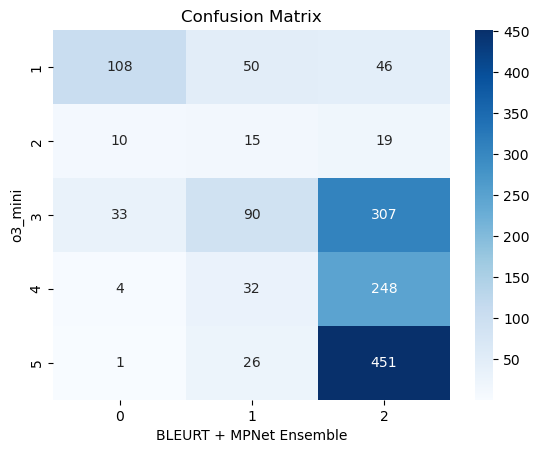

In [46]:
crosstab = pd.crosstab(
    df["o3_mini_score"],
    df["score"],
)

sns.heatmap(crosstab, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["0", "1", "2"],
            yticklabels=["1", "2", "3", "4", "5"])
plt.ylabel("o3_mini")
plt.xlabel("BLEURT + MPNet Ensemble")
plt.title("Confusion Matrix")
plt.show()

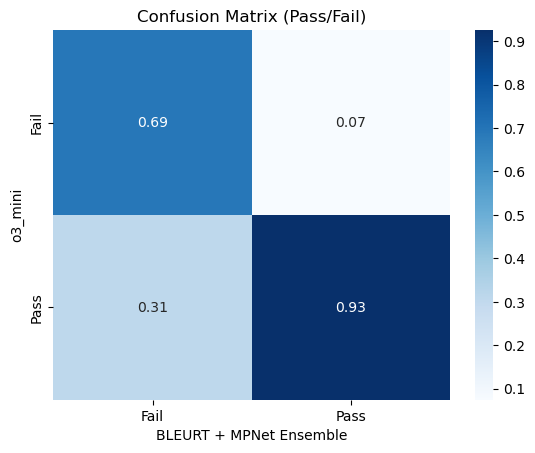

In [61]:
crosstab = pd.crosstab(
    df["o3_mini_score"] > 1,
    df["score"] > 0,
    normalize="columns",
)

sns.heatmap(crosstab, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=["Fail", "Pass"],
            yticklabels=["Fail", "Pass"])

plt.xlabel("BLEURT + MPNet Ensemble")
plt.ylabel("o3_mini")
plt.title("Confusion Matrix (Pass/Fail)")
plt.show()

In [51]:
pd.crosstab(
    df["score"] > 0,
    df["o3_mini_score"] > 2,
    margins=True
)

o3_mini_score,False,True,All
score,,,
False,118,38,156
True,130,1154,1284
All,248,1192,1440


## Quick Qualitative Analysis

In [56]:
with pd.option_context('display.max_colwidth', 0):
    would_fail_with_o3 = (
        df
        .query("score == 0 & `o3_mini_score` == 2")
        .rename(columns={
            "question": "Question",
            "answer": "Reference Answer",
            "response": "Student Response",
        })
    )
    display(would_fail_with_o3[["Question", "Reference Answer", "Student Response"]].sample(10))

,Question,Reference Answer,Student Response
294,What is the relationship between compound growth rates and compound interest rates based on the passage?,"They have the same formula for growth over time, with compound interest causing savings to grow dramatically and compound growth rates causing GDP to increase significantly.",It shows the growth of the rates and interests overtime
73,What were economic conditions like before 1870?,"Economic conditions before 1870 were marked by slow technological progress, natural disasters, and institutions that played a critical role in determining income levels.",The economies state were poor
259,What is the relationship between compound growth rates and compound interest rates based on the passage?,"They have the same formula for growth over time, with compound interest causing savings to grow dramatically and compound growth rates causing GDP to increase significantly.",They are directly related.
904,What is one reason why the average person can afford more food in modern times?,The dramatic rise in incomes allowed the average person to eat better and consume more calories.,increased agricultural productivity
1289,What is the relationship between productivity growth and average wage levels in an economy?,Productivity per hour is the most important determinant of the average wage level in any economy.,positive correlation?
905,What is one reason why the average person can afford more food in modern times?,The dramatic rise in incomes allowed the average person to eat better and consume more calories.,One reason is increased productivity in agriculture
89,What were economic conditions like before 1870?,"Economic conditions before 1870 were marked by slow technological progress, natural disasters, and institutions that played a critical role in determining income levels.",countries were more equal in gdp
264,What is the relationship between compound growth rates and compound interest rates based on the passage?,"They have the same formula for growth over time, with compound interest causing savings to grow dramatically and compound growth rates causing GDP to increase significantly.",a percentage increase over time
83,What were economic conditions like before 1870?,"Economic conditions before 1870 were marked by slow technological progress, natural disasters, and institutions that played a critical role in determining income levels.","There was relative global equality, though some nations experienced GDP growth while others saw decline."
1352,What is the relationship between productivity growth and average wage levels in an economy?,Productivity per hour is the most important determinant of the average wage level in any economy.,positive
